In [1]:
#1 Menambahkan Library yang akan kita butuhkan
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [6]:
#2 Load dataset
train_df = pd.read_csv(r"C:\Users\khouf\assignment\4212311008_YUNANDA SYAHPUTRA.csv")

# Pisahkan label & pixel
# format df.iloc[baris, kolom]
labels = train_df.iloc[:,0].values        # shape: (n_samples,)
images = train_df.iloc[:,1:].values       # shape: (n_samples, 784)

In [7]:
print("Jumlah sample:", labels.shape[0])

Jumlah sample: 88799


In [8]:
print("Dimensi pixel per sample:", images.shape[1])

Dimensi pixel per sample: 784


In [9]:
train_df

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88794,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88795,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88796,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#3 membagi sample per letter sebanyak 500, sehingga total ada 13K sample dari 88.8k sample

# format df.iloc[baris, kolom]
# simpan list kecil untuk tiap label
samples_per_class = 500
sampled_df = pd.DataFrame()

for label in range(1, 27):  # 1=A, 2=B, ..., 26=Z
    subset = train_df[train_df.iloc[:,0] == label]
    sampled = subset.sample(n=samples_per_class, random_state=42)
    sampled_df = pd.concat([sampled_df, sampled])

In [11]:
# cek
print(sampled_df.shape)  # harus (13000, 785)

(13000, 785)


In [12]:
sampled_df.shape[0]

13000

In [13]:
#4 Ambil labels & images dari 13K sampel hasil sampling
labels_sampled = sampled_df.iloc[:, 0].values
images_sampled = sampled_df.iloc[:, 1:].values

In [14]:
labels_sampled.shape

(13000,)

In [15]:
images_sampled.shape

(13000, 784)

In [16]:
#5 Ekstrak HOG feature dari 13k data yang udah kita ambil tadi

hog_features = []

for i in range(len(images_sampled)):
    img = images_sampled[i].reshape(28,28)  # reshape 1D → 2D per gambar
    feature = hog(img, orientations=9, pixels_per_cell=(8,8),
                  cells_per_block=(2,2), block_norm='L2-Hys')
    hog_features.append(feature)

hog_features = np.array(hog_features)

In [17]:
print(hog_features.shape)

(13000, 144)


In [18]:
# Rescale hog feature

from sklearn.preprocessing import StandardScaler
# === RESCALE FITUR ===
scaler = StandardScaler()
X = scaler.fit_transform(hog_features)
y = labels_sampled

In [19]:
#6 Mempersiapkan data untuk SVM kernel RBF

X = hog_features         # shape: (13000, 144)
y = labels_sampled       # shape: (13000,)

svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

In [20]:
# setting batch
batch_size = 100
n_samples = X.shape[0]
save_file = "y_results_partial_RBF.csv"

In [21]:
# resume checkpoint jika ada batch
try:
    df = pd.read_csv(save_file)
    start_index = len(df)  # mulai dari baris berikutnya
    y_true_all = df["y_true"].tolist()
    y_pred_all = df["y_pred"].tolist()
    print(f"Resuming from sample index {start_index}")
except FileNotFoundError:
    start_index = 0
    y_true_all = []
    y_pred_all = []
    print("Starting from scratch")

Resuming from sample index 4800


In [22]:
from tqdm import tqdm

In [23]:
cv = LeaveOneOut()
splits = list(cv.split(X))  # buat index dulu biar bisa resume

for i in tqdm(range(start_index, len(splits)), total=len(splits), initial=start_index, desc="LOOCV Progress"):
    train_ix, test_ix = splits[i]
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)

    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

    # checkpoint tiap 100 iterasi
    if (i+1) % 100 == 0:
        pd.DataFrame({"y_true": y_true_all, "y_pred": y_pred_all}).to_csv(save_file, index=False)

LOOCV Progress: 100%|██████████| 13000/13000 [10:54:12<00:00,  4.79s/it]     


In [24]:
# mengambil data y hasil LOOCV tadi

y_true = y_true_all
y_pred = y_pred_all

In [25]:
#8 Menampilkan Confusion Matix, ACC, PREC, F1
conf_matrix = confusion_matrix(y_true, y_pred)

In [26]:
conf_matrix

array([[412,   2,   2,   3,   3,   0,   8,   6,   1,   1,   0,   0,   4,
         10,   7,   0,  28,   2,   0,   3,   1,   0,   2,   0,   0,   5],
       [ 13, 414,   1,   2,   3,   1,   4,  36,   2,   0,   2,   4,   1,
          0,   2,   0,   4,   6,   3,   0,   0,   0,   0,   0,   0,   2],
       [  3,   0, 429,   0,  31,   1,  14,   0,   2,   0,   0,   3,   0,
          1,   9,   1,   2,   2,   2,   0,   0,   0,   0,   0,   0,   0],
       [  5,   8,   0, 438,   0,   0,   0,   3,   5,  12,   0,   1,   0,
          4,  17,   2,   0,   0,   0,   3,   0,   0,   0,   0,   0,   2],
       [  5,   4,  26,   0, 427,  20,   7,   0,   1,   0,   0,   0,   0,
          0,   3,   0,   0,   3,   2,   0,   0,   0,   0,   0,   0,   2],
       [  2,   1,   4,   0,   5, 443,   4,   1,   1,   1,   1,   2,   0,
          0,   0,   7,   2,   3,   4,  17,   0,   0,   0,   0,   0,   2],
       [ 12,  11,  17,   1,   6,   3, 340,   1,   3,   2,   0,   0,   0,
          2,   1,   0,  79,   3,   8,   3,   

In [29]:
!pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -----------------------

In [30]:
from mlxtend.plotting import plot_confusion_matrix

In [31]:
class_names = [chr(i) for i in range(65, 91)]  # A-Z

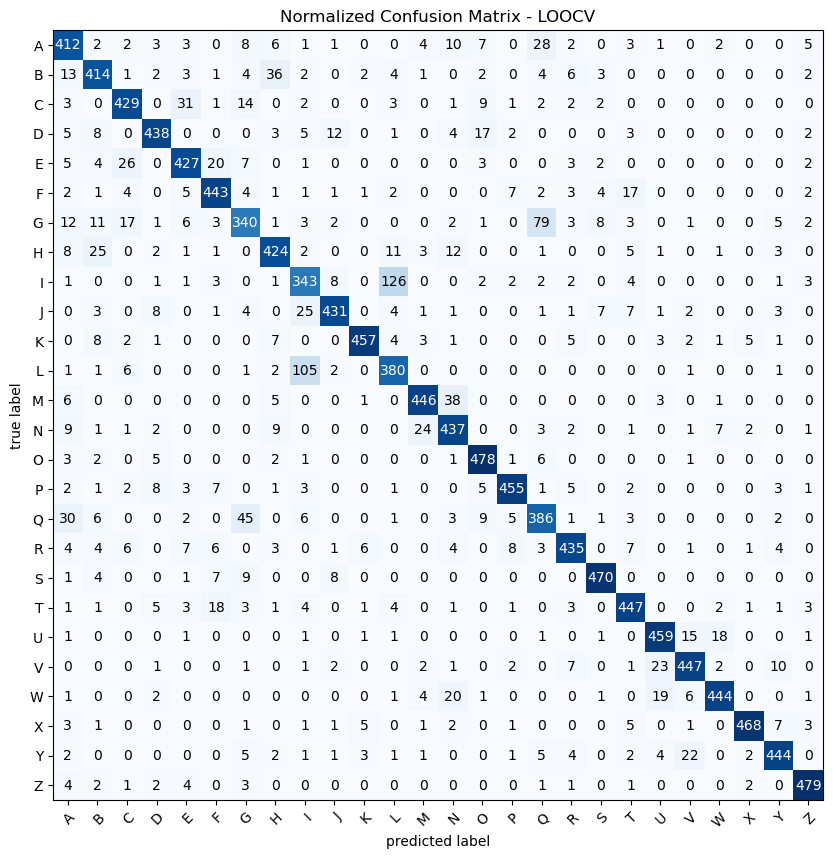

In [32]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names, figsize=(12,10))

plt.title("Normalized Confusion Matrix - LOOCV")
plt.show()

In [33]:
#9 Menampilkan Accuracy
accuracy = accuracy_score(y_true, y_pred)

In [34]:
accuracy

0.8640769230769231

In [35]:
#10 Menampilkan Presisi
precision = precision_score(y_true, y_pred, average= 'macro')

In [36]:
precision

0.8656012040507728

In [37]:
#11 Menampilkan F1 Score
f1 = f1_score(y_true, y_pred, average='macro')

In [38]:
f1

0.864443020347927